In [1]:
#pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [3]:
train_df = pd.read_csv(r"C:\Users\broya\OneDrive\Desktop\UM Internship\Instagram fake spammer genuine accounts\train.csv")
test_df = pd.read_csv(r"C:\Users\broya\OneDrive\Desktop\UM Internship\Instagram fake spammer genuine accounts\test.csv")

In [4]:
print("Train Data Head:\n", train_df.head())
print("\nTest Data Head:\n", test_df.head())

Train Data Head:
    profile pic  nums/length username  fullname words  nums/length fullname  \
0            1                  0.27               0                   0.0   
1            1                  0.00               2                   0.0   
2            1                  0.10               2                   0.0   
3            1                  0.00               1                   0.0   
4            1                  0.00               2                   0.0   

   name==username  description length  external URL  private  #posts  \
0               0                  53             0        0      32   
1               0                  44             0        0     286   
2               0                   0             0        1      13   
3               0                  82             0        0     679   
4               0                   0             0        1       6   

   #followers  #follows  fake  
0        1000       955     0  
1        2740   

In [5]:
print("\nTrain Data Info:\n")
train_df.info()
print("\nNull Values in Train Data:\n", train_df.isnull().sum())


Train Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           576 non-null    int64  
 1   nums/length username  576 non-null    float64
 2   fullname words        576 non-null    int64  
 3   nums/length fullname  576 non-null    float64
 4   name==username        576 non-null    int64  
 5   description length    576 non-null    int64  
 6   external URL          576 non-null    int64  
 7   private               576 non-null    int64  
 8   #posts                576 non-null    int64  
 9   #followers            576 non-null    int64  
 10  #follows              576 non-null    int64  
 11  fake                  576 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 54.1 KB

Null Values in Train Data:
 profile pic             0
nums/length username    0
fullname words          0
num

In [6]:
# Rename columns for easier handling
train_df.columns = train_df.columns.str.strip().str.lower().str.replace(' ', '_')
test_df.columns = test_df.columns.str.strip().str.lower().str.replace(' ', '_')


In [7]:
print("\nTest Data Info:\n")
test_df.info()
print("\nNull Values in Test Data:\n", test_df.isnull().sum())


Test Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile_pic           120 non-null    int64  
 1   nums/length_username  120 non-null    float64
 2   fullname_words        120 non-null    int64  
 3   nums/length_fullname  120 non-null    float64
 4   name==username        120 non-null    int64  
 5   description_length    120 non-null    int64  
 6   external_url          120 non-null    int64  
 7   private               120 non-null    int64  
 8   #posts                120 non-null    int64  
 9   #followers            120 non-null    int64  
 10  #follows              120 non-null    int64  
 11  fake                  120 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 11.4 KB

Null Values in Test Data:
 profile_pic             0
nums/length_username    0
fullname_words          0
nums/

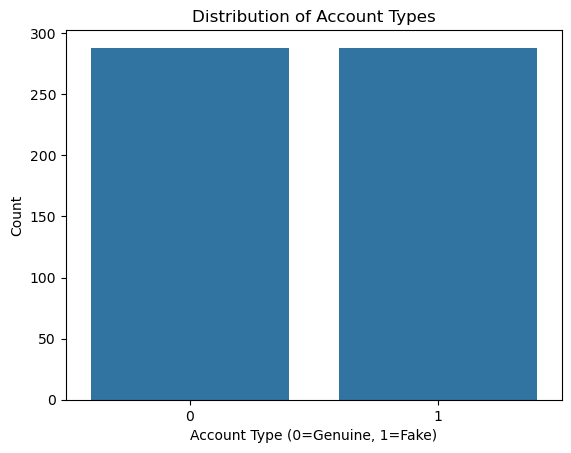

In [8]:
# Distribution of Target Variable
sns.countplot(data=train_df, x='fake')
plt.title('Distribution of Account Types')
plt.xlabel('Account Type (0=Genuine, 1=Fake)')
plt.ylabel('Count')
plt.show()

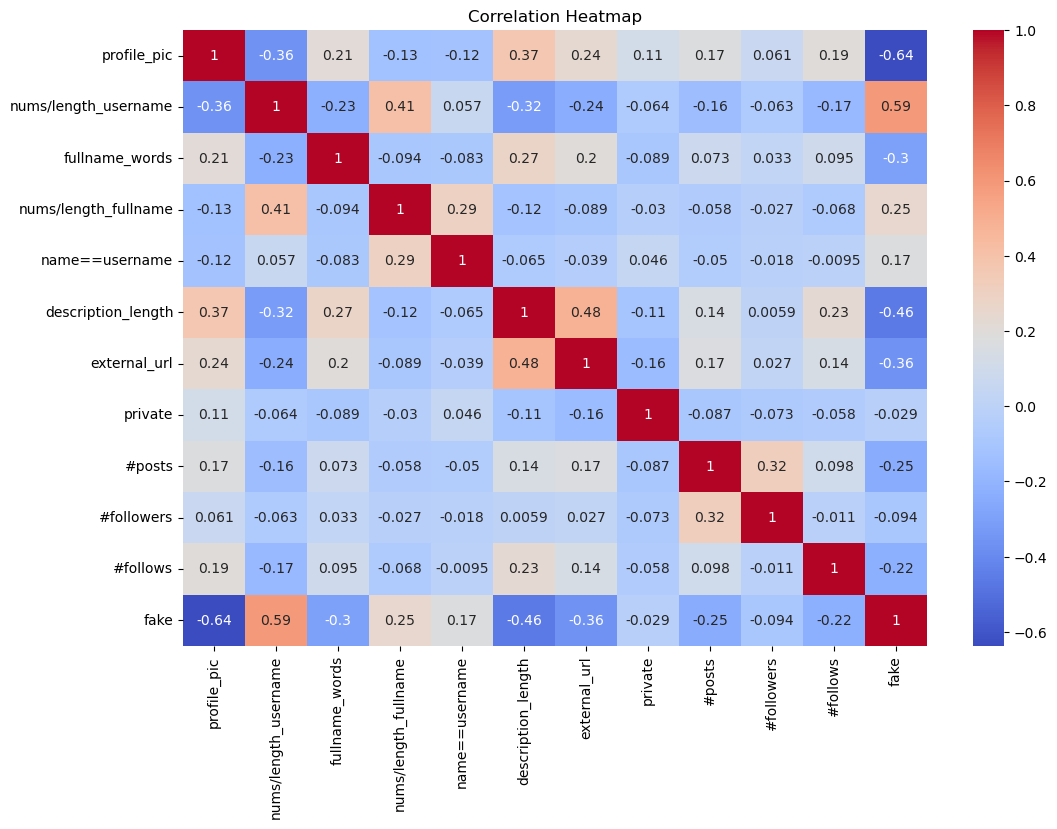

In [9]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

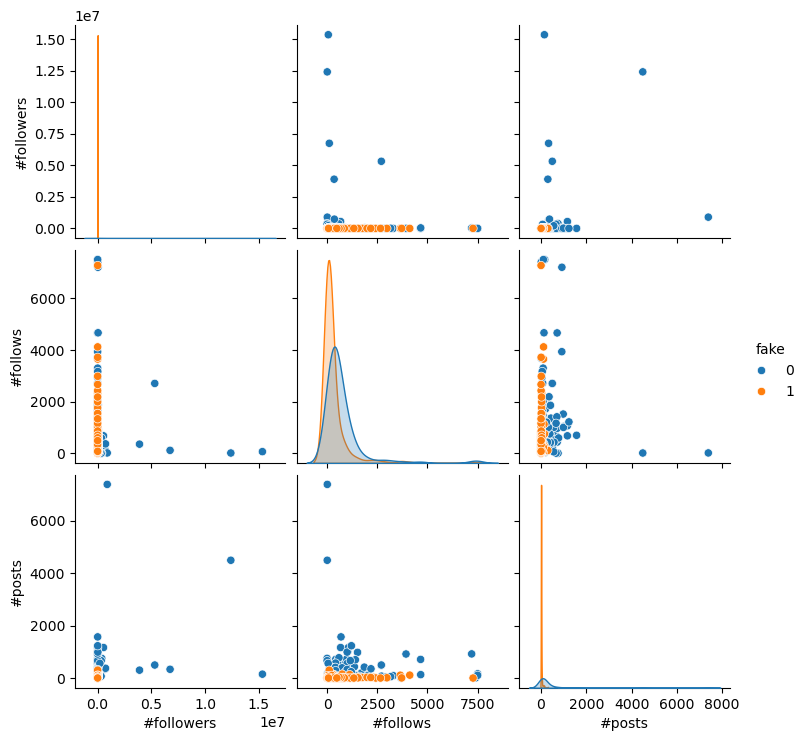

In [10]:
# Pairplot for Selected Features
selected_features = ['#followers', '#follows', '#posts']
sns.pairplot(train_df[selected_features + ['fake']], hue='fake')
plt.show()


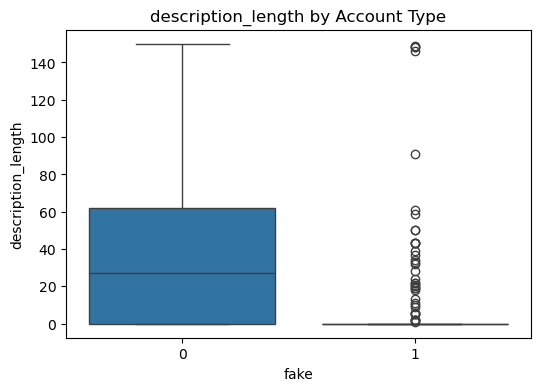

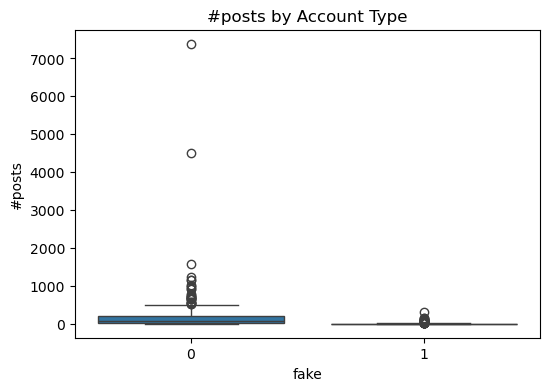

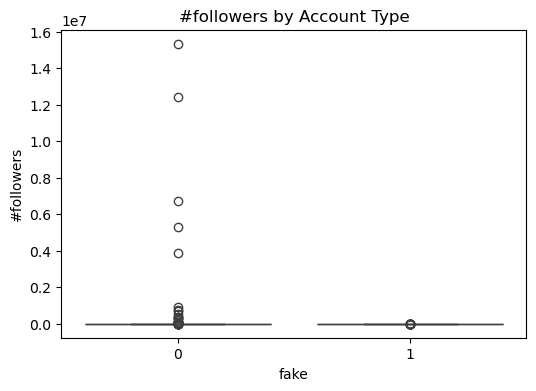

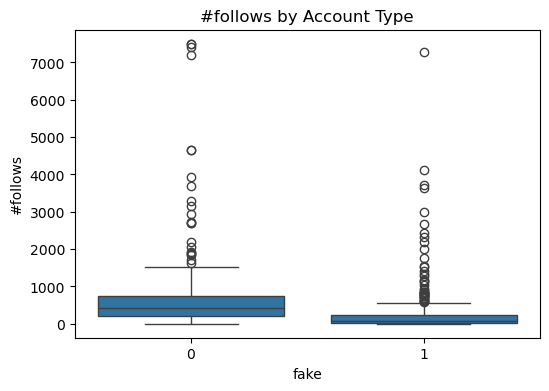

In [11]:
# Boxplots to Check Outliers
selected_features = ['description_length', '#posts', '#followers', '#follows']
for feature in selected_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='fake', y=feature, data=train_df)
    plt.title(f'{feature} by Account Type')
    plt.show()



In [12]:
# Define target and drop unnecessary columns
print("\nTarget column is 'fake' for classification.")
X = train_df.drop(['fake'], axis=1)
y = train_df['fake']


Target column is 'fake' for classification.


In [13]:
# Handle categorical features if present
categorical_cols = X.select_dtypes(include='object').columns
print("\nCategorical Columns to Encode:", categorical_cols.tolist())



Categorical Columns to Encode: []


In [14]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

In [15]:
# Save test IDs for later prediction
if 'id' in test_df.columns:
    test_ids = test_df['id']
    test_features = test_df.drop(['id'], axis=1)
else:
    test_features = test_df.copy()

In [16]:
# Ensure the test set has same columns as training set
test_features = test_features[X.columns]

In [17]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_features)


In [18]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [19]:
## Model Training and Evaluation

In [20]:
results = []
best_model = None
best_acc = 0

In [21]:
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"\nModel: {name}")
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))
    return name, acc

In [22]:
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]


In [23]:
results = []
for name, model in models:
    result = evaluate_model(name, model)
    results.append(result)



Model: Logistic Regression
Accuracy: 0.8620689655172413
Confusion Matrix:
 [[60  3]
 [13 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88        63
           1       0.93      0.75      0.83        53

    accuracy                           0.86       116
   macro avg       0.88      0.85      0.86       116
weighted avg       0.87      0.86      0.86       116


Model: Decision Tree
Accuracy: 0.853448275862069
Confusion Matrix:
 [[56  7]
 [10 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87        63
           1       0.86      0.81      0.83        53

    accuracy                           0.85       116
   macro avg       0.85      0.85      0.85       116
weighted avg       0.85      0.85      0.85       116


Model: Random Forest
Accuracy: 0.9224137931034483
Confusion Matrix:
 [[61  2]
 [ 7 46]]
Classification Report:
   

C:\Users\broya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:57:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


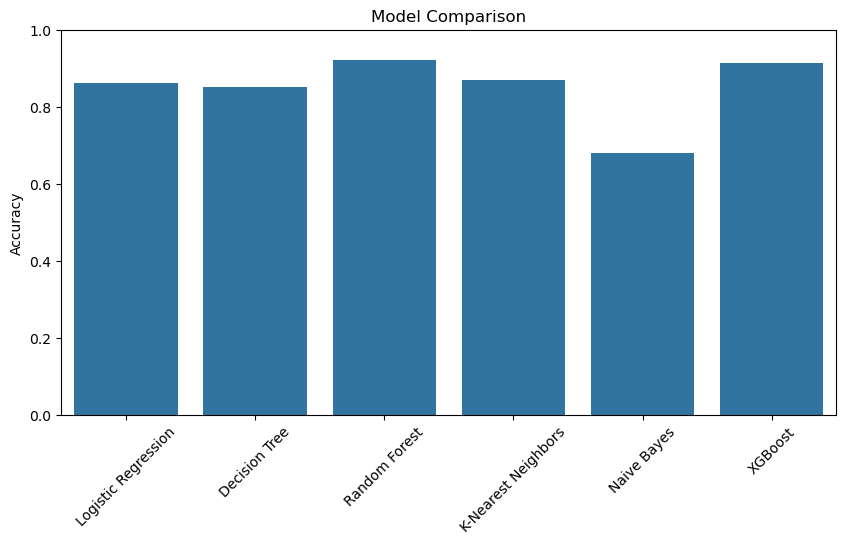

In [24]:
# Plot model comparison
model_names, accuracies = zip(*results)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(model_names), y=list(accuracies))
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

In [25]:
try:
    final_predictions = best_model.predict(test_scaled)
    submission_df = pd.DataFrame({'id': test_ids, 'fake': final_predictions})
    submission_df.to_csv('final_predictions.csv', index=False)
    print("\nPredictions saved to 'final_predictions.csv'")
except Exception as e:
    print("\nError during prediction:", str(e))



Error during prediction: 'NoneType' object has no attribute 'predict'


In [26]:
# Check if the best model has feature_importances_ attribute
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
    feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
    plt.title('Feature Importance')
    plt.ylabel('Importance Score')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()
else:
    print("This model does not provide feature importances.")


This model does not provide feature importances.


In [27]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [31]:
best_model = None
best_acc = 0

for name, model in models:
    model_name, acc, trained_model = evaluate_model(name, model)
    results.append((model_name, acc))
    
    if acc > best_acc or best_model is None:
        best_acc = acc
        best_model = trained_model




Model: Logistic Regression
Accuracy: 0.8620689655172413
Confusion Matrix:
 [[60  3]
 [13 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88        63
           1       0.93      0.75      0.83        53

    accuracy                           0.86       116
   macro avg       0.88      0.85      0.86       116
weighted avg       0.87      0.86      0.86       116



ValueError: not enough values to unpack (expected 3, got 2)

In [32]:
import shap
shap.initjs()

# SHAP only works natively with tree-based models
if isinstance(best_model, (RandomForestClassifier, XGBClassifier, DecisionTreeClassifier)):
    explainer = shap.Explainer(best_model, X_train)
    shap_values = explainer(X_val)

    # Plot summary of feature importances
    shap.summary_plot(shap_values, X_val, feature_names=X.columns)
else:
    print("SHAP currently supports only tree-based models. Best model is not compatible.")


SHAP currently supports only tree-based models. Best model is not compatible.
